<a href="https://colab.research.google.com/github/Pager07/FinalYearProject/blob/master/ActionRecognitionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Ladder Board

- Downloading the data 
-Importing 
  - Fastai
  - Google drive
- Understanding the data 
  - Loading the data
    - setting up variables
      - root_dir (Path to main project folder) 
      - base_dir (Path to data folder)
    - Loading Images 
      - Looking at images in drive and cleaning up data 
- Creating DataObject
  - Loading action labels
  - ItemList
    - spliting it into train and val
- Creating Databunch
  - Look at batches 
    - Clean up the data in Drive

- Creating the learner
  - Finding best LR 

- Fitting the model in smaller(images)
  - Fit frozen layers
  - Unfreez and fit 

- Fitting the mode in larger images 

#Importing FastAi Library

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline
from fastai.vision import *

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
from google.colab import drive

In [15]:
drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


#Understanding the data

In [0]:
root_dir = '/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data2'
base_dir = root_dir + '/Basketball'
path = Path(base_dir)

In [0]:
img = open_image(path/'train'/'3-pointer failure'/'17_209,68_3-pointer failure.png')

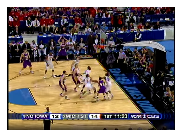

In [0]:
img.show()

#Creating DataObject,DataLoader and Databunch

In [0]:
#We are only fliping the image in the y-axis. I may play around with maz_zoon and wrap later to see how it affects the results
transforms = get_transforms(do_flip=True, max_rotate=None , max_zoom=0 , max_warp=0.)

In [0]:
#When this function is called, it gets passsed the filePath(PATH OBJECT) of the image
#Example: PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data2/train/2_other 2-pointer failure.png')
def get_label(filePath):
  '''RETURNS LABELS'''
  label = str(filePath).split('/')[-1].split('.')[0].split('_')[-1]
  return label

In [0]:
'''TEST'''
a = path/'train'/'3-pointer failure'/'17_209,68_3-pointer failure.png'
str(a).split('/')[-1].split('.')[0].split('_')[-1]

'3-pointer failure'

In [0]:
'''TEST'''
b = path/'train'/'24_3-pointer success.png'
str(b).split('/')[-1].split('.')[0].split('_')[1]

'3-pointer success'

In [0]:
#Creating Databunch. 
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid="valid",
                                  ds_tfms = transforms, size =128,
                                  num_workers = 4).normalize(imagenet_stats);

In [0]:
data.c , data.classes , len(data.train_ds) , len(data.valid_ds) , len(data.train_dl) , len(data.valid_dl)

(9,
 ['3-pointer failure',
  '3-pointer success',
  'free-throw failure',
  'free-throw success',
  'layup failure',
  'layup success',
  'other 2-pointer failure',
  'other 2-pointer success',
  'slam dunk'],
 4611,
 576,
 72,
 9)

In [0]:
data.classes

['3-pointer failure',
 '3-pointer success',
 'free-throw failure',
 'free-throw success',
 'layup failure',
 'layup success',
 'other 2-pointer failure',
 'other 2-pointer success',
 'slam dunk']

In [0]:
data

ImageDataBunch;

Train: LabelList (4611 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
3-pointer failure,3-pointer failure,3-pointer failure,3-pointer failure,3-pointer failure
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data2/Basketball;

Valid: LabelList (576 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
layup success,layup success,layup success,layup success,layup success
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data2/Basketball;

Test: None

# Training:resnet50

In [0]:
learn = cnn_learner(data, models.resnet50 , metrics= error_rate)

In [0]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,3.313724,2.826658,0.862847,08:26
1,3.089762,2.601645,0.810764,04:23
2,2.850496,2.527596,0.831597,04:24
3,2.506368,2.345760,0.805556,04:25
4,2.265436,2.182046,0.802083,04:29
5,2.104628,2.197477,0.800347,04:34
6,2.043649,2.073378,0.779514,04:34
7,1.964375,2.057904,0.788194,04:34
8,1.925199,2.008691,0.782986,04:38
9,1.861037,2.035827,0.795139,04:44


In [0]:
learn.save('stage1-resnet50-size128')

In [0]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


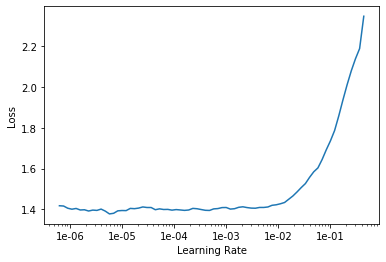

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-04, 1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,1.642094,2.041482,0.750000,04:30
1,1.862708,2.616048,0.791667,04:29
2,1.957084,2.057626,0.755208,04:29
3,1.920739,2.042152,0.737847,04:30
4,1.801021,1.900345,0.789931,04:30
5,1.683899,1.761668,0.708333,04:33
6,1.517623,1.740542,0.673611,04:35
7,1.327889,1.836176,0.670139,04:40
8,1.110882,1.951344,0.725694,04:43
9,0.942305,1.940662,0.690972,04:40


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


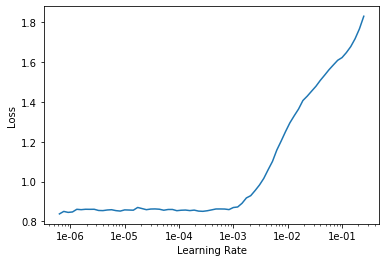

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(1e-05, 1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.852815,1.980627,0.696181,04:32
1,0.833187,2.119862,0.687500,04:31
2,0.800960,2.267234,0.685764,04:34
3,0.740677,2.421027,0.710069,04:47
4,0.619499,2.711904,0.717014,04:53
5,0.518688,2.742247,0.710069,04:42
6,0.394999,2.904300,0.755208,04:37
7,0.316910,3.001170,0.737847,04:34
8,0.266860,3.037095,0.739583,04:35
9,0.229129,3.048779,0.741319,04:35


#Results

In [0]:
learn.load("stage2-resnet50-size128")
learn.data = data

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

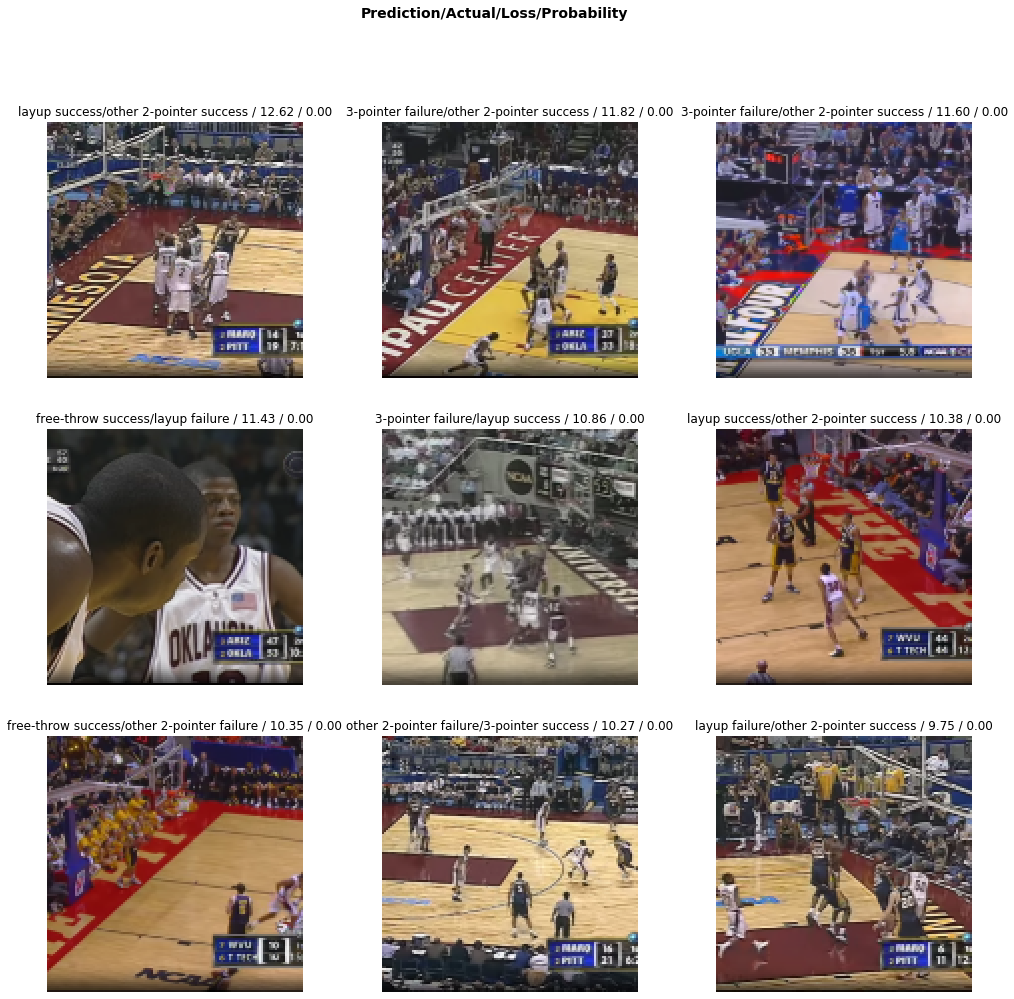

In [27]:
interp.plot_top_losses(9,figsize=(17,16))

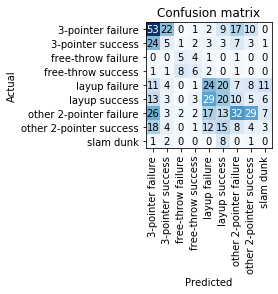

In [28]:
interp.plot_confusion_matrix()

In [0]:
learn.export()

In [40]:
learn.predict(img)

(Category slam dunk,
 tensor(8),
 tensor([0.2806, 0.0563, 0.0007, 0.0016, 0.0179, 0.0364, 0.0090, 0.0494, 0.5480]))

#Training on bigger images(OVER FITS)

In [0]:
#Creating Databunch. 
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid="valid",
                                  ds_tfms = transforms, size =(360,490),
                                  num_workers = 4,bs=4).normalize(imagenet_stats);

In [0]:
learn = cnn_learner(data, models.resnet50 , metrics= error_rate)

In [0]:
learn.data = data

In [0]:
learn.load('stage2-resnet50-size128')

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


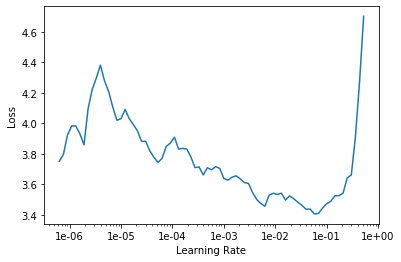

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(1e-03, 1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,3.363533,3.016770,0.791667,07:27
1,13.269667,895.126282,0.899306,07:34
2,20.764597,3288.543457,0.819444,07:47
3,13.972492,1374.301025,0.961806,07:48
4,10.349580,1691.383911,0.789931,07:36
5,7.282907,556.149414,0.850694,07:32
6,3.715374,46.499763,0.857639,07:35
7,2.506938,70.730614,0.835069,07:21
8,2.153431,71.449181,0.798611,07:18
9,1.984449,52.034222,0.734375,07:19


In [0]:
learn.save("stage1-resnet50-size360Hx490W")

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


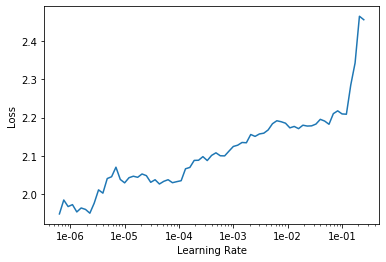

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,error_rate,time
0,1.979968,27.131998,0.751736,07:34
1,2.026042,60.625042,0.741319,07:30
2,1.933819,86.984604,0.765625,07:30
3,1.996125,34.088512,0.748264,07:30
4,2.028023,39.054306,0.753472,07:28
5,1.944560,26.634491,0.756944,07:29
6,1.956695,30.168854,0.748264,07:29
7,1.995336,16.136156,0.734375,07:28
8,1.970547,34.438824,0.751736,07:30
9,1.951177,10.584154,0.763889,07:28


In [0]:
learn.save("stage2-resnet50-size360Hx490W")

#Results (Using weiths obtained from training bigger images)

In [0]:
learn.load("stage2-resnet50-size360Hx490W")

In [0]:
learn.data = data

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

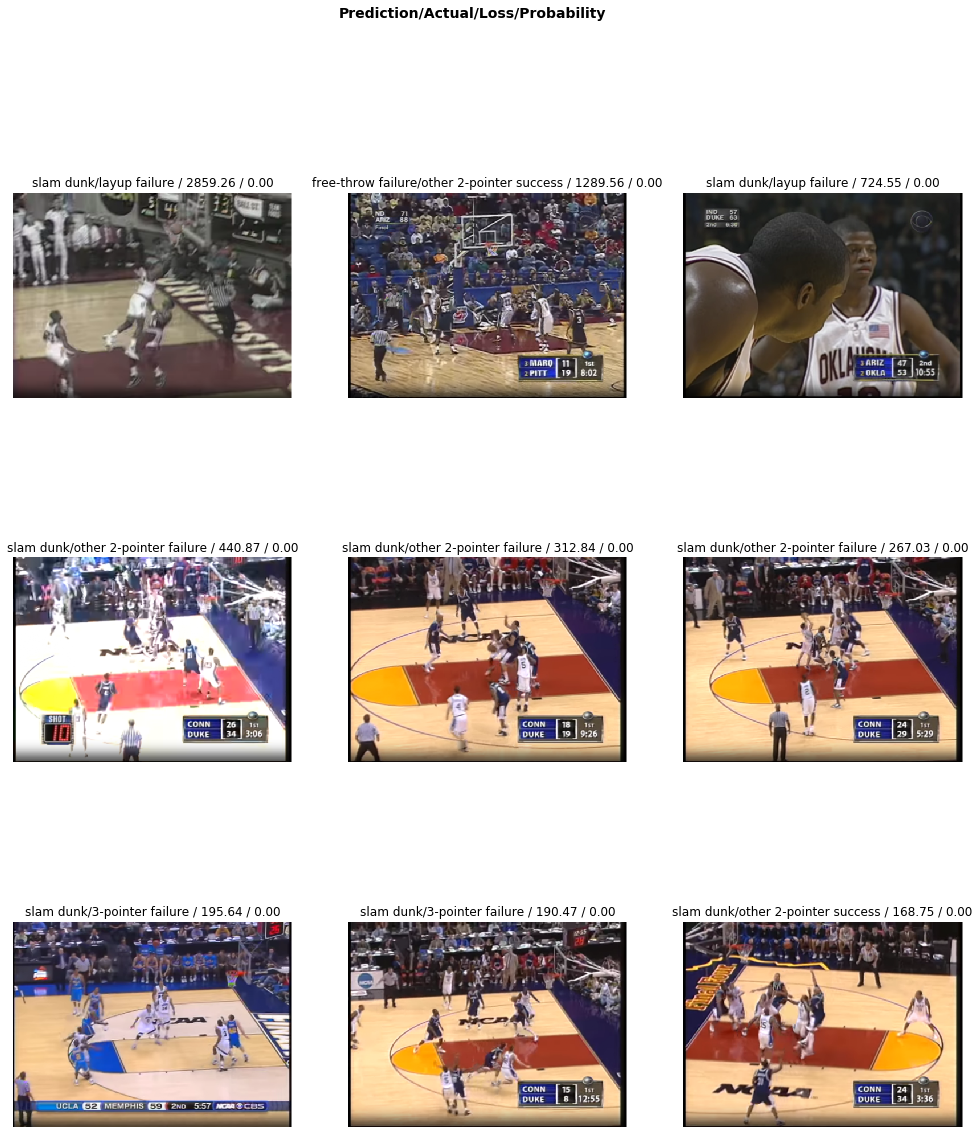

In [35]:
interp.plot_top_losses(9, figsize=(17,19))

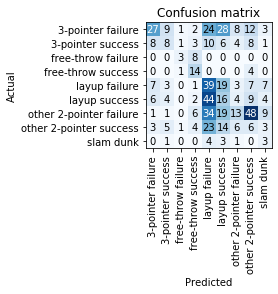

In [36]:
interp.plot_confusion_matrix()